In [224]:
import pandas as pd
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)
pd.set_option("display.precision",5)

In [2]:
import matplotlib.pyplot as plt, seaborn as sns, numpy as np

In [3]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn import dummy

In [4]:
import datetime, timeit

In [5]:
from IPython.display import clear_output

In [6]:
import warnings
warnings.simplefilter('ignore')

# <p style='text-align:center'>Fonctions</p>

In [393]:
def explained_variable(bench, var_name):
    y_brut = bench[var_name]
    y_log = y_brut.apply(lambda x : np.log(x))
    return y_log

def explanatory_variables(bench, nrj_score):
    bench['total_gfa'] = bench['total_gfa'].apply(lambda x : np.log(x) if x!=0 else 0)
    bench['building_gfa'] = bench['building_gfa'].apply(lambda x : np.log(x) if x!=0 else 0)
    bench['parking_gfa'] = bench['parking_gfa'].apply(lambda x : np.log(x) if x!=0 else 0)
    bench['lput_gfa'] = bench['lput_gfa'].apply(lambda x : np.log(x) if x!=0 else 0)
    bench['sput_gfa'] = bench['sput_gfa'].apply(lambda x : np.log(x) if x!=0 else 0)
    liste = ['age','nb','nf','building_gfa','parking_gfa','lput_gfa','sput_gfa', 'electricity_pct', 'natural_gas_pct', 'steam_pct']
    listecat = ['district_code','type','lput','sput','electricity_bool','natural_gas_bool', 'steam_bool']
    if (nrj_score):
        liste = ['age','nb','nf','building_gfa','parking_gfa','lput_gfa','sput_gfa','electricity_pct', 'natural_gas_pct', 'steam_pct','energy_score']
    Xnum = bench[liste].values
    X_before_encoding = Xnum
    enc = OneHotEncoder(handle_unknown='ignore')
    Xcat = bench[listecat].values
    Xenc = enc.fit_transform(Xcat).toarray()
    X = np.concatenate((Xnum, Xenc),axis=1)
    return X, X_before_encoding

def standardize(X_train, X_test, y_train, y_test, n):
    scaler = StandardScaler()
    scaler.fit(X_train[:,0:n])
    X_train_std = np.concatenate((scaler.transform(X_train[:,0:n]) , X_train[:,n:]),axis=1)
    X_test_std = np.concatenate((scaler.transform(X_test[:,0:n]) , X_test[:,n:]),axis=1)
    return X_train_std, X_test_std

def get_time(start_time, end_time):
    m = (end_time - start_time)//60
    s = (end_time - start_time) - m*60
    return m,s

def squared_error(y_pred, y_true):
    y = (y_true - y_pred)**2
    return np.sqrt(y.sort_values(ascending = False))

def model_vs_real(y_pred, y_true, exp_variable):
    if exp_variable == 'ghg_emission':
        gap = 100
    else:
        gap = 2*10**6
    fig, ax = plt.subplots(figsize=(15,15))
    ax.scatter(y_pred, y_true, label = 'model vs real')
    ax.plot(y_true, y_true, linestyle = '--', color = 'r', label = 'perfect model')
    ax.plot(y_true , y_true + gap, linestyle = '--', color = 'y', label = '+2x10^6')
    ax.plot(y_true , y_true - gap, linestyle = '--', color = 'y', label = '-2x10^6')
    ax.set_xlabel("y_pred")
    ax.set_ylabel("y_true")
    ax.set_title('Model VS Real')
    ax.legend()
    plt.show()

def regularization_path(lambdas):
    coeffs = []
    for l in lambdas:
        ridge = Ridge(alpha=l).fit(X_train_std, y_train)
        coeffs.append([ridge.intercept_] + list(ridge.coef_))
    coeff_lambdas = pd.DataFrame(coeffs,columns=["b_" + str(i) for i in range(0,129)],index=lambdas)
    fig, ax = plt.subplots(figsize=(15,15))
    #[100,68,34,112,122,83,95,54,94,38,95,127,126,53,45,25,36,102,108]
    for i in range(20):
        idx = np.random.randint(0,128)
        ax.plot(coeff_lambdas.index, coeff_lambdas.iloc[:,idx], label = 'beta_'+str(idx))
    plt.legend()
    ax.set_title('Chemins de régularisation',fontsize=18)
#     ax.set_xscale('log')
    ax.invert_xaxis()
    plt.show()


def regularization_path_lasso(lambdas):
    coeffs = []
    for l in lambdas:
        lasso = Lasso(alpha=l)
        lasso.fit(X_train_std, y_train)
        coeffs.append([lasso.intercept_] + list(lasso.coef_))
    coeff_lambdas = pd.DataFrame(coeffs,columns=["b_" + str(i) for i in range(0,129)],index=lambdas)
    fig, ax = plt.subplots(figsize=(15,15))
    #[100,68,34,112,122,83,95,54,94,38,95,127,126,53,45,25,36,102,108]
    for i in range(20):
        idx = np.random.randint(1,128)
        ax.plot(coeff_lambdas.index, coeff_lambdas.iloc[:,idx], label = 'beta_'+str(idx))
    plt.legend()
    ax.set_title('Chemins de régularisation',fontsize=18)
    # ax.set_yscale('log')
    ax.invert_xaxis()
    plt.show()

def show_metric(y_pred_train, y_train, y_pred_test, y_test, time):
    y_train_exp = [np.exp(x) for x in y_train]
    y_test_exp = [np.exp(x) for x in y_test]
    train_error = mean_squared_error(y_pred_train,y_train_exp,squared=False)
    test_error = mean_squared_error(y_pred_test,y_test_exp,squared=False)
    train_r2 = r2_score(y_train_exp,y_pred_train)
    test_r2 = r2_score(y_test_exp,y_pred_test)
    met = pd.DataFrame(data = [[train_error, test_error, train_r2, test_r2, time]], columns = ["RMSE_train","RMSE_test","R2_train","R2_test","TIME"], index=["valeur"])
    display(met)
    return train_error, test_error, train_r2, test_r2, time

def show_best_param(best_params):
    display(pd.DataFrame(best_params,index=['value']))

def adjusted_r2(y, y_pred,n,p):
#     adjusted_r2_scorer = make_scorer(adjusted_r2,n=X.shape[0],p=X.shape[1])
    return 1-(1-r2_score(y, y_pred))*((n-1)/(n-p))

def lin_fit(X,y):
    n, p = X.shape[0], X.shape[1]
    X_1 = np.concatenate((np.ones((n,1)),X),axis=1)
    beta = np.matmul(np.matmul(np.linalg.pinv(np.matmul(np.transpose(X_1),X_1)),np.transpose(X_1)),y)
    return beta

def lin_predict(X,beta):
    n=X.shape[0]
    X_1 = np.concatenate((np.ones((n,1)),X),axis=1)
    y_pred = np.matmul(X_1,beta)
    return y_pred

def make_results():
    resultats = pd.DataFrame(columns=['Target']+liste_model)
    resultats.at[0,'Target'] = 'energy_use'
    resultats.at[1,'Target'] = 'ghg_emission'
    return resultats

def save_results(train_error,test_error,train_r2,test_r2,time,exp_variable,model):
    resultats_r2_train.loc[resultats_r2_train['Target']==exp_variable,model] = train_r2
    resultats_r2_test.loc[resultats_r2_test['Target']==exp_variable,model] = test_r2
    resultats_rmse_train.loc[resultats_r2_test['Target']==exp_variable,model] = train_error
    resultats_rmse_test.loc[resultats_r2_test['Target']==exp_variable,model] = test_error
    resultats_time.loc[resultats_r2_test['Target']==exp_variable,model] = "("+str(time[0])+", "+str(time[1])+")"

# <p style='text-align:center'>Paramètres</p>

In [378]:
nrj_score = False
feature_select = False
exp_variable = "ghg_emission"
liste_model = ['Regression simple', 'Regression Ridge', 'Regression Lasso', 'Regression Elastic Net', 'Linear SVR', 'MLP Regression', 'Random Forest', 'GradientBoost', 'Dummy (MEAN)']

# <p style='text-align:center'>Features Engineering </p>

In [379]:
bench = pd.read_excel("benchmark_cleaned.xlsx")

X, X_before_encoding = explanatory_variables(bench, nrj_score)

y = explained_variable(bench = bench, var_name = exp_variable)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=5)

X_train_std, X_test_std = standardize(X_train, X_test, y_train, y_test, X_before_encoding.shape[1])

# <p style='text-align:center'> Simple Linear Regression </p>

In [339]:
# Regression Linéaire Simple

start_time = timeit.default_timer()

beta = lin_fit(X_train_std, y_train)
y_pred_train_simple, y_pred_test_simple  = lin_predict(X_train_std,beta), lin_predict(X_test_std,beta)

#Inversion du passage au log
y_pred_train_simple, y_pred_test_simple = [np.exp(x) for x in y_pred_train_simple],[np.exp(x) for x in y_pred_test_simple]

end_time = timeit.default_timer()

time_simple= get_time(start_time, end_time)

train_error_simple, test_error_simple, train_r2_simple, test_r2_simple, time_simple = show_metric(y_pred_train_simple, y_train, y_pred_test_simple, y_test, time_simple)

,RMSE_train,RMSE_test,R2_train,R2_test,TIME
valeur,64.33217,87.46829,0.69151,0.45418,"(0.0, 0.024837699995259754)"


-14513.661687832751

In [340]:
# save_results(train_error_simple, test_error_simple, train_r2_simple, test_r2_simple, time_simple, exp_variable,'Regression simple')

# <p style='text-align:center'> Ridge Linear Regression </p>

In [341]:
# Regression linéaire Ridge

start_time = timeit.default_timer()

cv_ridge_params_ghg = {'alpha' : np.logspace(-4,4,9)}
cv_ridge_params_nrj = {'alpha' : np.logspace(-4,4,9)}
    
ridge_param_choice = {'ridge_ghg_emission' : cv_ridge_params_ghg,'ridge_energy_use' : cv_ridge_params_nrj}

cv_ridge_params = ridge_param_choice['ridge_' + exp_variable]

cv_ridge = GridSearchCV(Ridge(), cv_ridge_params, cv=5, scoring='neg_root_mean_squared_error')
cv_ridge.fit(X_train_std, y_train)

ridge = Ridge(alpha=cv_ridge.best_params_['alpha'])
ridge.fit(X_train_std, y_train)
y_pred_train_ridge, y_pred_test_ridge = ridge.predict(X_train_std), ridge.predict(X_test_std)

# Inversion du passage au log
y_pred_train_ridge, y_pred_test_ridge = [np.exp(x) for x in y_pred_train_ridge],[np.exp(x) for x in y_pred_test_ridge]

end_time = timeit.default_timer()

time_ridge = get_time(start_time, end_time)

train_error_ridge, test_error_ridge, train_r2_ridge, test_r2_ridge, time_ridge = show_metric(y_pred_train_ridge, y_train, y_pred_test_ridge, y_test, time_ridge)
show_best_param(cv_ridge.best_params_)

,RMSE_train,RMSE_test,R2_train,R2_test,TIME
valeur,64.58277,81.21935,0.6891,0.52938,"(0.0, 0.30600609999964945)"


,alpha
value,1.0


In [343]:
# save_results(train_error_ridge, test_error_ridge, train_r2_ridge, test_r2_ridge, time_ridge, exp_variable,'Regression Ridge')

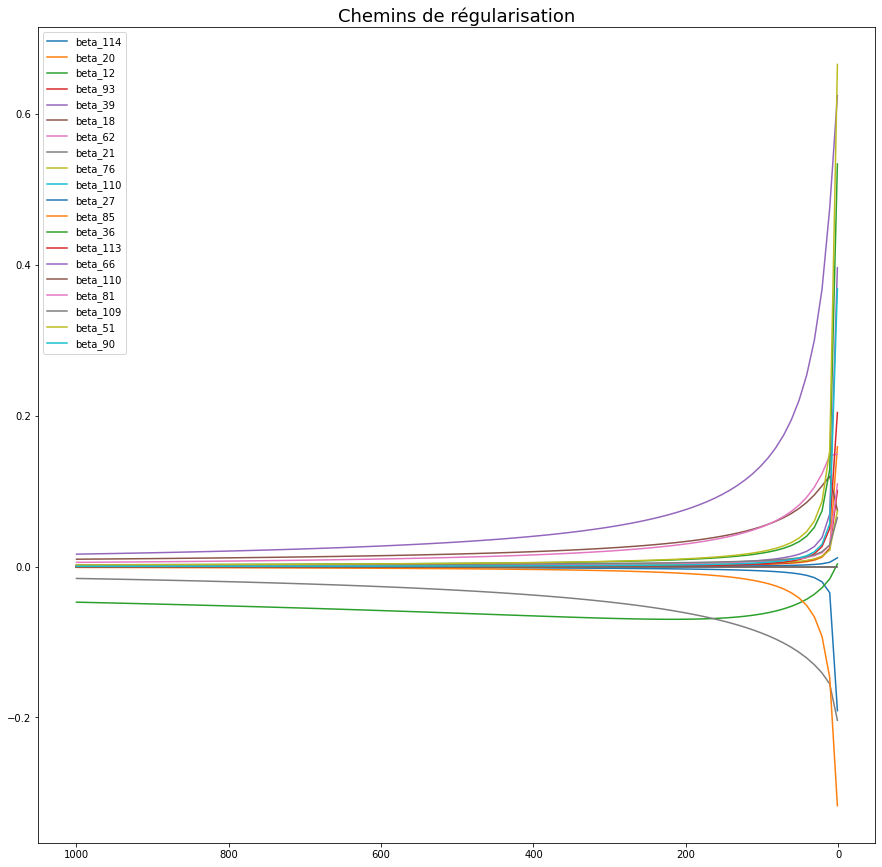

In [215]:
regularization_path(np.linspace(1,1000,100))

In [109]:
# model_vs_real(y_pred_test_ridge, y_test, exp_variable)

# <p style='text-align:center'> Lasso Linear Regression </p>

In [344]:
# Regression linéaire Lasso

start_time = timeit.default_timer()

cv_lasso_params_ghg = {'alpha':np.logspace(-4,4,9)}
cv_lasso_params_nrj = {'alpha':np.logspace(-4,4,9)}

lasso_param_choice = {'lasso_ghg_emission':cv_lasso_params_ghg, 'lasso_energy_use':cv_lasso_params_nrj}

cv_lasso_params = lasso_param_choice['lasso_' + exp_variable]

cv_lasso = GridSearchCV(Lasso(fit_intercept=True),cv_lasso_params,cv=5,scoring='neg_root_mean_squared_error')
cv_lasso.fit(X_train_std, y_train)

lasso = Lasso(alpha=cv_lasso.best_params_['alpha'], fit_intercept=True)
lasso.fit(X_train_std, y_train)
y_pred_train_lasso, y_pred_test_lasso = lasso.predict(X_train_std), lasso.predict(X_test_std)

# Inversion du passage au log
y_pred_train_lasso, y_pred_test_lasso = [np.exp(x) for x in y_pred_train_lasso],[np.exp(x) for x in y_pred_test_lasso]

end_time = timeit.default_timer()

time_lasso = get_time(start_time, end_time)

train_error_lasso, test_error_lasso, train_r2_lasso, test_r2_lasso, time_lasso = show_metric(y_pred_train_lasso, y_train, y_pred_test_lasso, y_test, time_lasso)
show_best_param(cv_lasso.best_params_)

,RMSE_train,RMSE_test,R2_train,R2_test,TIME
valeur,64.26147,84.21092,0.69218,0.49408,"(0.0, 1.538251300007687)"


,alpha
value,0.0001


In [345]:
# save_results(train_error_lasso, test_error_lasso, train_r2_lasso, test_r2_lasso, time_lasso, exp_variable,'Regression Lasso')

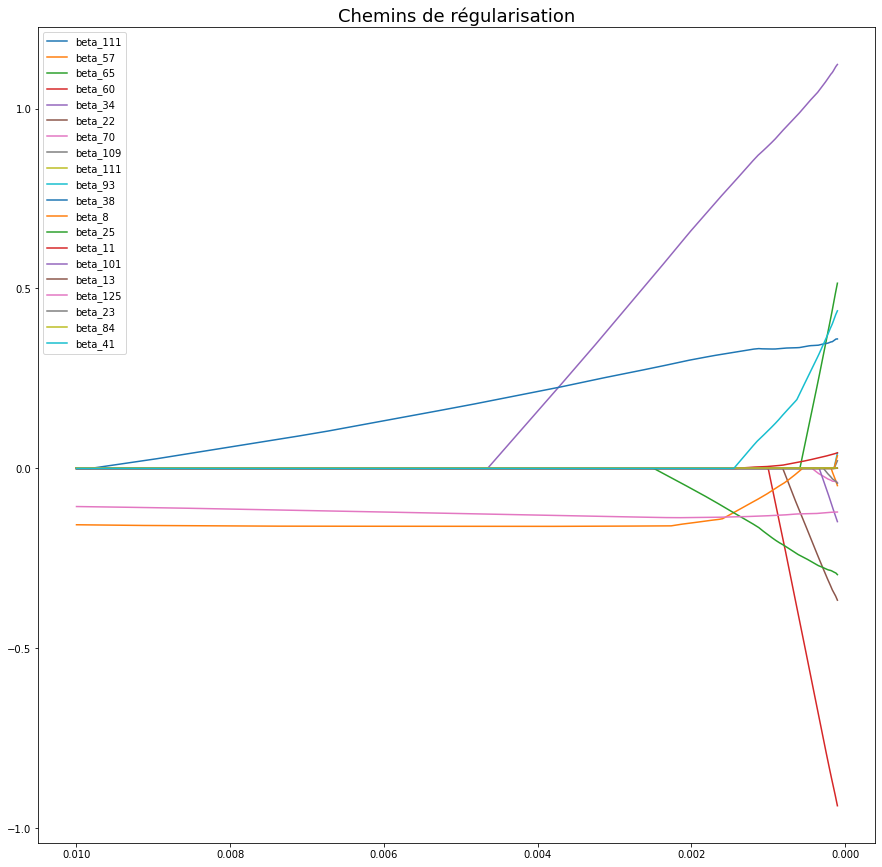

In [251]:
lambdas = np.logspace(-4,-2,500)
regularization_path_lasso(lambdas)

In [111]:
# model_vs_real(y_pred_test_lasso, y_test, exp_variable)

# <p style='text-align:center'> Elastic Net Linear Regression </p>

In [375]:
# Regression linéaire Elastic Net

start_time = timeit.default_timer()

cv_elastic_params_ghg = {'alpha':np.logspace(-4,4,8),'l1_ratio':np.logspace(-4,4,8)}
cv_elastic_params_nrj = {'alpha':np.logspace(-4,4,8),'l1_ratio':np.logspace(-4,4,8)}

elastic_param_choice = {'elastic_ghg_emission':cv_elastic_params_ghg,'elastic_energy_use':cv_elastic_params_nrj}

cv_elastic_params = elastic_param_choice['elastic_' + exp_variable]

cv_elastic = GridSearchCV(ElasticNet(), cv_elastic_params, cv=5, scoring='neg_root_mean_squared_error')
cv_elastic.fit(X_train_std, y_train)

elastic = ElasticNet(alpha = cv_elastic.best_params_['alpha'], l1_ratio = cv_elastic.best_params_['l1_ratio'], random_state=0)

elastic.fit(X_train_std, y_train)
y_pred_train_elastic, y_pred_test_elastic = elastic.predict(X_train_std), elastic.predict(X_test_std)

# Inversion du passage au log
y_pred_train_elastic, y_pred_test_elastic = [np.exp(x) for x in y_pred_train_elastic],[np.exp(x) for x in y_pred_test_elastic]

end_time = timeit.default_timer()

time_elastic = get_time(start_time, end_time)
train_error_elastic, test_error_elastic, train_r2_elastic, test_r2_elastic, time_elastic = show_metric(y_pred_train_elastic, y_train, y_pred_test_elastic, y_test, time_elastic)
show_best_param(cv_elastic.best_params_)

,RMSE_train,RMSE_test,R2_train,R2_test,TIME
valeur,2.59831e+06,3.06016e+06,0.70249,0.55927,"(0.0, 7.959315200001583)"


,alpha,l1_ratio
value,0.00139,0.0001


In [376]:
# save_results(train_error_elastic, test_error_elastic, train_r2_elastic, test_r2_elastic, time_elastic, exp_variable,'Regression Elastic Net')

In [194]:
# model_vs_real(y_pred_test_elastic, y_test, exp_variable)

# <p style='text-align:center'> Support Vector Regressor </p>

In [352]:
start_time = timeit.default_timer()

cv_svr_params_ghg = {'C' : [0.01,0.1,1],'degree':[2,3,4], 'kernel' : ['linear','poly']}
cv_svr_params_nrj = {'C' : [0.01,0.1,1],'degree':[1], 'kernel' : ['linear']}

svr_param_choice = {'svr_ghg_emission':cv_svr_params_ghg, 'svr_energy_use':cv_svr_params_nrj}

cv_svr_params = svr_param_choice['svr_' + exp_variable]

cv_svr = GridSearchCV(SVR(kernel = 'linear'), cv_svr_params, cv=5, scoring='neg_root_mean_squared_error')

cv_svr.fit(X_train_std, y_train)

svr = SVR(kernel = cv_svr.best_params_["kernel"], C=cv_svr.best_params_["C"], degree = cv_svr.best_params_["degree"])
svr.fit(X_train_std, y_train)
y_pred_train_svr, y_pred_test_svr = svr.predict(X_train_std), svr.predict(X_test_std)

# Inversion du passage au log
y_pred_train_svr, y_pred_test_svr = [np.exp(x) for x in y_pred_train_svr],[np.exp(x) for x in y_pred_test_svr]

end_time = timeit.default_timer()

time_svr = get_time(start_time, end_time)
train_error_svr, test_error_svr, train_r2_svr, test_r2_svr, time_svr = show_metric(y_pred_train_svr, y_train, y_pred_test_svr, y_test, time_svr)
show_best_param(cv_svr.best_params_)

,RMSE_train,RMSE_test,R2_train,R2_test,TIME
valeur,55.86319,76.28294,0.76738,0.58485,"(0.0, 20.887200499986648)"


,C,degree,kernel
value,1,2,poly


In [353]:
# save_results(train_error_svr, test_error_svr, train_r2_svr, test_r2_svr, time_svr, exp_variable, 'Linear SVR')

In [120]:
# model_vs_real(y_pred_test_svr, y_test, 'ghg_emission')

# <p style='text-align:center'> MLP Regressor </p>

In [354]:
start_time = timeit.default_timer()

cv_mlp_params_ghg = {'hidden_layer_sizes':[30,50,80,100],'alpha':[0.01,0.1,1,10,100]}
cv_mlp_params_nrj = {'hidden_layer_sizes':[30,50,80,100],'alpha':[1,10,100]}

mlp_param_choice = {'mlp_ghg_emission':cv_mlp_params_ghg, 'mlp_energy_use':cv_mlp_params_nrj}

cv_mlp_params = mlp_param_choice['mlp_' + exp_variable]

cv_mlp = GridSearchCV(MLPRegressor(solver = 'lbfgs', max_iter = 500, early_stopping = True, learning_rate='adaptive',random_state=40),
                   cv_mlp_params,
                   cv=5,
                   scoring='neg_root_mean_squared_error')

cv_mlp.fit(X_train_std, y_train)

regr = MLPRegressor(solver = 'lbfgs', 
                    hidden_layer_sizes = cv_mlp.best_params_['hidden_layer_sizes'],
                    max_iter = 500,
                    alpha = cv_mlp.best_params_['alpha'],
                    early_stopping = True,
                    learning_rate='adaptive',random_state=90).fit(X_train_std, y_train)
y_pred_train_mlp, y_pred_test_mlp = regr.predict(X_train_std), regr.predict(X_test_std)

# Inversion du passage au log
y_pred_train_mlp, y_pred_test_mlp = [np.exp(x) for x in y_pred_train_mlp],[np.exp(x) for x in y_pred_test_mlp]

end_time = timeit.default_timer()

time_mlp= get_time(start_time, end_time)
train_error_mlp, test_error_mlp, train_r2_mlp, test_r2_mlp, time_mlp = show_metric(y_pred_train_mlp, y_train, y_pred_test_mlp, y_test, time_mlp)
show_best_param(cv_mlp.best_params_)

,RMSE_train,RMSE_test,R2_train,R2_test,TIME
valeur,13.60026,81.8797,0.98621,0.5217,"(4.0, 45.277333099991665)"


,alpha,hidden_layer_sizes
value,1,80


In [355]:
# save_results(train_error_mlp, test_error_mlp, train_r2_mlp, test_r2_mlp, time_mlp, exp_variable, 'MLP Regression')

In [356]:
# model_vs_real(y_pred_test_mlp, y_test, exp_variable)

# <p style='text-align:center'> Random Forest </p>

In [362]:
start_time = timeit.default_timer()

cv_rfr_params_ghg = {'n_estimators':[10,20,30,40],'max_depth':[20,50,70,90],'min_samples_leaf':[2,4,8],'min_samples_split':[4,8,12]}
cv_rfr_params_nrj = {'n_estimators':[50,60,70],'max_depth':[5,10,20],'min_samples_leaf':[2,4,8,10,20],'min_samples_split':[20,50,70]}

rfr_param_choice = {'rfr_ghg_emission':cv_rfr_params_ghg, 'rfr_energy_use':cv_rfr_params_nrj}

cv_rfr_params = rfr_param_choice['rfr_' + exp_variable]

cv_rfr = GridSearchCV(RandomForestRegressor(), cv_rfr_params, cv=5, scoring='neg_root_mean_squared_error')

# cv_rfr.fit(X_train_std_2, y_train)
cv_rfr.fit(X_train_std, y_train)

rfr = RandomForestRegressor(n_estimators = cv_rfr.best_params_['n_estimators'],
                            max_depth = cv_rfr.best_params_['max_depth'],
                            min_samples_leaf = cv_rfr.best_params_['min_samples_leaf'],
                            min_samples_split = cv_rfr.best_params_['min_samples_split'])

if feature_select :
    rfr_0 = rfr.fit(X_train_std, y_train)
    select = SelectFromModel(rfr, prefit=True, threshold='mean')
    X_train_std_2 = select.transform(X_train_std)
    X_test_std_2 = select.transform(X_test_std)
    rfr.fit(X_train_std_2, y_train)
    y_pred_train_rfr, y_pred_test_rfr = rfr.predict(X_train_std_2), rfr.predict(X_test_std_2)
else :
    rfr.fit(X_train_std, y_train)
    y_pred_train_rfr, y_pred_test_rfr = rfr.predict(X_train_std), rfr.predict(X_test_std)

end_time = timeit.default_timer()

time_rfr = get_time(start_time, end_time)

# Inversion du passage au log
y_pred_train_rfr, y_pred_test_rfr = [np.exp(x) for x in y_pred_train_rfr],[np.exp(x) for x in y_pred_test_rfr]

train_error_rfr, test_error_rfr, train_r2_rfr, test_r2_rfr, time_rfr = show_metric(y_pred_train_rfr, y_train, y_pred_test_rfr, y_test, time_rfr)
show_best_param(cv_rfr.best_params_)

,RMSE_train,RMSE_test,R2_train,R2_test,TIME
valeur,38.19354,65.41951,0.89126,0.69468,"(2.0, 28.0490015999967)"


,max_depth,min_samples_leaf,min_samples_split,n_estimators
value,90,2,4,40


In [363]:
# save_results(train_error_rfr, test_error_rfr, train_r2_rfr, test_r2_rfr, time_rfr, exp_variable, 'Random Forest')

In [91]:
# model_vs_real(y_pred_test_rfr, np.array(y_test), exp_variable)

# <p style='text-align:center'> GradientBoost </p>

In [365]:
start_time = timeit.default_timer()

cv_gbr_params_ghg = {'n_estimators':[20,50,70],'max_depth':[5,10,20],'min_samples_leaf':[2,4,8,10,20],'min_samples_split':[20,50,70]}
cv_gbr_params_nrj = {'n_estimators':[50,60,70],'max_depth':[5,10,20],'min_samples_leaf':[2,4,8,10,20],'min_samples_split':[20,50,70]}

gbr_param_choice = {'gbr_ghg_emission':cv_gbr_params_ghg,'gbr_energy_use':cv_gbr_params_nrj}

cv_gbr_params = gbr_param_choice['gbr_' + exp_variable]

cv_gbr = GridSearchCV(GradientBoostingRegressor(), cv_gbr_params, cv=5, scoring='neg_root_mean_squared_error')

cv_gbr.fit(X_train_std, y_train)

gbr = GradientBoostingRegressor(n_estimators = cv_gbr.best_params_['n_estimators'],
                            max_depth = cv_gbr.best_params_['max_depth'],
                            min_samples_leaf = cv_gbr.best_params_['min_samples_leaf'],
                            min_samples_split = cv_gbr.best_params_['min_samples_split'])

if feature_select :
    gbr_0 = gbr.fit(X_train_std, y_train)
    select = SelectFromModel(gbr_0, prefit=True, threshold=0.003)
    X_train_std_2 = select.transform(X_train_std)
    X_test_std_2 = select.transform(X_test_std)
    gbr.fit(X_train_std_2, y_train)
    y_pred_train_gbr, y_pred_test_gbr= gbr.predict(X_train_std_2), gbr.predict(X_test_std_2)
else :
    gbr.fit(X_train_std, y_train)
    y_pred_train_gbr, y_pred_test_gbr= gbr.predict(X_train_std), gbr.predict(X_test_std)

# Inversion du passage au log
y_pred_train_gbr, y_pred_test_gbr = [np.exp(x) for x in y_pred_train_gbr],[np.exp(x) for x in y_pred_test_gbr]


end_time = timeit.default_timer()

time_gbr= get_time(start_time, end_time)
train_error_gbr, test_error_gbr, train_r2_gbr, test_r2_gbr, time_gbr = show_metric(y_pred_train_gbr, y_train, y_pred_test_gbr, y_test, time_gbr)
show_best_param(cv_gbr.best_params_)

,RMSE_train,RMSE_test,R2_train,R2_test,TIME
valeur,19.16535,57.18224,0.97262,0.76672,"(5.0, 45.41592200000014)"


,max_depth,min_samples_leaf,min_samples_split,n_estimators
value,20,4,50,70


In [366]:
# save_results(train_error_gbr, test_error_gbr, train_r2_gbr, test_r2_gbr, time_gbr, exp_variable, 'GradientBoost')

In [ ]:
# model_vs_real(y_pred_test_ada, y_test, exp_variable)

# <p style='text-align:center'> Dummy </p>

In [380]:
start_time = timeit.default_timer()

dum = dummy.DummyRegressor(strategy='mean')
dum.fit(X_train_std, y_train)
y_pred_train_dummy, y_pred_test_dummy = dum.predict(X_train_std), dum.predict(X_test_std)

# Inversion du passage au log
y_pred_train_dummy, y_pred_test_dummy = [np.exp(x) for x in y_pred_train_dummy],[np.exp(x) for x in y_pred_test_dummy]

end_time = timeit.default_timer()

time_dummy = get_time(start_time, end_time)

train_error_dummy, test_error_dummy, train_r2_dummy, test_r2_dummy, time_dummy = show_metric(y_pred_train_dummy, y_train, y_pred_test_dummy, y_test, time_dummy)

,RMSE_train,RMSE_test,R2_train,R2_test,TIME
valeur,124.3718,126.62832,-0.15301,-0.14395,"(0.0, 0.01307739999901969)"


In [381]:
# save_results(train_error_dummy, test_error_dummy, train_r2_dummy, test_r2_dummy, time_dummy, exp_variable, 'Dummy (MEAN)')

In [ ]:
# model_vs_real(y_pred_test_dummy, y_test, exp_variable)

# <p style='text-align:center'> Synthèse des résultats et choix du modèle </p>

In [394]:
resultats_rmse_train, resultats_rmse_test, resultats_r2_train, resultats_r2_test, resultats_time = pd.read_excel('rmse_train.xlsx'), pd.read_excel('rmse_test.xlsx'), pd.read_excel('r2_train.xlsx'), pd.read_excel('r2_test.xlsx'), pd.read_excel('time.xlsx')

In [395]:
resultats_r2_test

,Target,Regression simple,Regression Ridge,Regression Lasso,Regression Elastic Net,Linear SVR,MLP Regression,Random Forest,GradientBoost,Dummy (MEAN)
0,energy_use,0.52594,0.55745,0.54204,0.55927,0.59020,0.60132,0.74886,0.81181,-0.14210
1,ghg_emission,0.45418,0.52938,0.49408,0.54005,0.58485,0.52170,0.69468,0.76672,-0.14395


In [396]:
resultats_rmse_test

,Target,Regression simple,Regression Ridge,Regression Lasso,Regression Elastic Net,Linear SVR,MLP Regression,Random Forest,GradientBoost,Dummy (MEAN)
0,energy_use,3.17377e+06,3.06650e+06,3.11941e+06,3.06016e+06,2.95083e+06,2.91054e+06,2.31004e+06,1.99967e+06,4.92619e+06
1,ghg_emission,8.74683e+01,8.12194e+01,8.42109e+01,8.02940e+01,7.62829e+01,8.18797e+01,6.54195e+01,5.71822e+01,1.26628e+02


# <p style='text-align:center'> Energy Star Score </p>

In [183]:
for target in ['energy_use','ghg_emission']:
    for nrj in [True, False]:
        message = 'Avec Energy Star Score (' if nrj else 'Sans Energy Star Score ('
        bench = pd.read_excel("benchmark_cleaned.xlsx")
        X, X_before_encoding = explanatory_variables(bench, nrj)
        y = explained_variable(bench = bench, var_name = target)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=5)
        X_train_std, X_test_std = standardize(X_train, X_test, y_train, y_test, X_before_encoding.shape[1])
        gbr = GradientBoostingRegressor(n_estimators = cv_gbr.best_params_['n_estimators'],
                            max_depth = cv_gbr.best_params_['max_depth'],
                            min_samples_leaf = cv_gbr.best_params_['min_samples_leaf'],
                            min_samples_split = cv_gbr.best_params_['min_samples_split'])
        gbr.fit(X_train_std, y_train)
        y_pred_train_gbr, y_pred_test_gbr = gbr.predict(X_train_std), gbr.predict(X_test_std)
        # Inversion du passage au log
        y_pred_train_gbr, y_pred_test_gbr = [np.exp(x) for x in y_pred_train_gbr],[np.exp(x) for x in y_pred_test_gbr]
        print(message + target + ') :')
        show_metric(y_pred_train_gbr, y_train, y_pred_test_gbr, y_test, 'undefined', True)

Avec Energy Star Score (energy_use) :


,RMSE_train,RMSE_test,R2_train,R2_test,TIME
valeur,669932.231,1.797e+06,0.98,0.848,undefined


Sans Energy Star Score (energy_use) :


,RMSE_train,RMSE_test,R2_train,R2_test,TIME
valeur,823244.177,2.003e+06,0.97,0.811,undefined


Avec Energy Star Score (ghg_emission) :


,RMSE_train,RMSE_test,R2_train,R2_test,TIME
valeur,16.678,53.845,0.979,0.793,undefined


Sans Energy Star Score (ghg_emission) :


,RMSE_train,RMSE_test,R2_train,R2_test,TIME
valeur,19.165,57.226,0.973,0.766,undefined
